<a href="https://colab.research.google.com/github/KameswaraRaoDoddi/MyProject/blob/master/CovidIndia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
data = '/content/drive/MyDrive/AIML/CovidIndia/data2.csv'

In [14]:
class NoFitFoundError(Exception):
    """fit() method needs to be called."""

    def __init__(self):
        """Exception initialization."""
        super().__init__("No fit was found. Please fit the model data first.")


class NoSimulationFoundError(Exception):
    """simulation() method needs to be called."""

    def __init__(self):
        """Exception initialization."""
        super().__init__("No simulation was found. Please simulate the data first.")

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.integrate import odeint



In [16]:
!pip install lmfit

In [17]:
from lmfit import Model, Parameters

In [28]:
class Covid19India:
    def __init__(self):
        self.__fit_return = None
        self.__simulation_return = None
        self.__name = "India"
        self.__population = 1380493070 #69348367 #29399000 #112374333 #  #  
        self.__data = pd.DataFrame(pd.read_csv(data, index_col=0))
    
    @property
    def name(self) -> str:
        """Get the name."""
        return self.__name
    
    @property
    def population(self) -> int:
        """Get the population size."""
        return self.__population

    @property
    def data(self) -> pd.DataFrame:
        """Get the covid data."""
        return self.__data

    @property
    def best_fit(self) -> np.ndarray:
        """Get best fit."""
        if self.__fit_return is None:
            raise NoFitFoundError()
        return np.array(
            [i * self.population for i in self.__fit_return["best_fit"]]
        )

    @property
    def r0(self) -> np.float64:
        """Get r0."""
        if self.__fit_return is None:
            raise NoFitFoundError()
        return self.__fit_return["r0"]

    @property
    def r2(self) -> np.float64:
        """Get r2."""
        if self.__fit_return is None:
            raise NoFitFoundError()
        return self.__fit_return["r2"]
    
    @property
    def curves(self) -> pd.DataFrame:
        """Get SEIRD simulation curves."""
        if self.__simulation_return is None:
            raise NoSimulationFoundError()
        return pd.DataFrame(
            data={
                "susceptible": self.__simulation_return["S"],
                "exposed": self.__simulation_return["E"],
                "infected": self.__simulation_return["I"],
                "recovered": self.__simulation_return["R"],
                "dead": self.__simulation_return["D"],
            }
        )
        
    def fit(self):
        """Fit the real data into the SEIRD model."""
        if self.__fit_return is None:
            scaled_cases = np.array([i / self.population for i in self.data["confirmed"]])
            x = np.linspace(0.0, len(scaled_cases), len(scaled_cases))

            params = Parameters()
            params.add("r0", value=1.4, min=0.0, max=5.0)
            params.add("gamma", value=0.1, min=0.0, max=1.0)
            params.add("delta", value=0.1, min=0.0, max=1.0)
            params.add("alpha", value=0.2, min=0.0, max=1.0)
            params.add("rho", value=0.1, min=0.0, max=1.0)
            params.add("population", value=self.population, vary=False)
            params.add("fit", value=True, vary=False)

            mod = Model(_seird)
            model_return = mod.fit(scaled_cases, params, method="leastsq", x=x)
            # model_return = np.asarray([e[0] for e in model_return])
            _, _, r_value, _, _ = linregress(model_return.best_fit, scaled_cases)
            print("ro",model_return.best_values["r0"],"gamma",model_return.best_values["gamma"],"delta",model_return.best_values["delta"],
                  "alpha",model_return.best_values["alpha"],"rho",model_return.best_values["rho"])
            print(model_return.fit_report())
            print(model_return.residual.var())
            self.__fit_return = {
                "best_fit": model_return.best_fit,
                "r0": model_return.best_values["r0"],
                "r2": r_value ** 2,
                "gamma": model_return.best_values["gamma"],
                "delta": model_return.best_values["delta"],
                "alpha": model_return.best_values["alpha"],
                "rho": model_return.best_values["rho"],
            }
        
    def plot_fit(self, filename: str = ""):
        """Plot fit curve.

        Parameters
        ----------
            - filename: output PNG file name.

        """
        if self.__fit_return is not None:

            x = pd.to_datetime(self.data.index)

            plt.figure(figsize=(10, 4))
            plt.plot_date(x, self.data["confirmed"], "-")
            plt.plot(x, self.best_fit)
            plt.legend(
                [
                    "real",
                    "fit (R2: {:.2f} | R0: {:.2f})".format(self.r2, self.r0),
                ]
            )
            plt.title("{} - SEIRD model fit".format(self.name))
            plt.xlabel("time (since first confirmed infection)")
            plt.ylabel("population")
            if len(filename) != 0:
                plt.savefig("{}.png".format(filename))
            return plt
        
    def simulation(self, days_ahead: int = 100):
        """Compute the seird model simulation curves.

        Parameters
        ----------
            - days_ahead: day ahead of real data to be simulated.

        """
        if self.__fit_return is not None:
            scaled_cases = np.array([i / self.population for i in self.data["confirmed"]])
            x = np.linspace(0.0, len(scaled_cases)+ days_ahead, len(scaled_cases) + days_ahead)
            S, E, I, R, D = _seird(x, self.r0, self.__fit_return["gamma"], self.__fit_return["delta"], self.__fit_return["alpha"],
                self.__fit_return["rho"], population=self.population, fit=False)

            self.__simulation_return = {"S": S, "E": E, "I": I, "R": R, "D": D}
            
            
    def plot_simulation(self, filename: str = ""):
        """Plot SEIRD simulation curves.

        Parameters
        ----------
            - filename: output PNG file name.

        """
        if self.__simulation_return is not None:

            real_data = pd.to_datetime(self.data.index)
            print(real_data)
            x = pd.date_range(start=real_data[0], periods=len(self.curves["susceptible"]))
            
            f, ax = plt.subplots(1, 1, figsize=(10, 5))
            ax.plot_date(x, list(map(lambda x: x * self.population, self.curves["susceptible"])), "b", alpha=0.7, linewidth=2, label="susceptible")
            print(list(map(lambda x: x * self.population, self.curves["infected"])))
            print(list(map(lambda x: x * self.population, self.curves["dead"])))
            ax.plot_date(x, list(map(lambda x: x * self.population, self.curves["exposed"])), "y", alpha=0.7, linewidth=2, label="exposed")
            ax.plot_date(x, list(map(lambda x: x * self.population, self.curves["infected"])), "r", alpha=0.7, linewidth=2, label="infected")
            ax.plot_date(x, list(map(lambda x: x * self.population, self.curves["recovered"])), "g", alpha=0.7, linewidth=2, label="recovered")
            ax.plot_date(x, list(map(lambda x: x * self.population, self.curves["dead"])), "k", alpha=0.7, linewidth=2, label="dead")
            ax.plot_date(x, list(map(lambda x: x * self.population, self.curves["dead"]+ self.curves["recovered"]+ self.curves["infected"]+ self.curves["exposed"]+self.curves["susceptible"])
                                                                                                         ), "c--", alpha=0.7, linewidth=2, label="Total")
            # ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')

            ax.set_ylabel("population")
            ax.set_xlabel("time (since first confirmed infection)")

            ax.yaxis.set_tick_params(length=0)
            ax.xaxis.set_tick_params(length=0)
            ax.grid(b=True, which="major", c="w", lw=2, ls="-")
            legend = ax.legend()
            legend.get_frame().set_alpha(0.5)
            for spine in ("top", "right", "bottom", "left"):
                ax.spines[spine].set_visible(False)

            plt.title("{} - SEIRD Simulation".format(self.name))
            if len(filename) != 0:
                 plt.savefig("{}.png".format(filename))
            return plt


In [29]:
def _seird(x, r0, gamma, delta, alpha, rho, population, fit):
    def deriv(y, x, r0, gamma, delta, alpha, rho):
        beta = r0 * gamma
        S, E, I, R, D = y
        dSdt = -beta * S * I
        dEdt = beta * S * I - delta * E
        dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
        dRdt = (1 - alpha) * gamma * I
        dDdt = alpha * rho * I
        return dSdt, dEdt, dIdt, dRdt, dDdt

    I0 = 1 / population
    S0 = 1 - I0
    y0 = [S0, I0, I0, 0.0, 0.0]
    ysol = odeint(deriv, y0, x, args=(r0, gamma, delta, alpha, rho))

    S, E, I, R, D = ysol.T
    if fit:
        return I
    else:
        return [S, E, I, R, D]

In [30]:
ind = Covid19India()

In [31]:
ind.fit()

ro 4.524118002141922 gamma 0.09680127525577875 delta 0.27104866867934174 alpha 0.05594583282236604 rho 0.012744258257842866
[[Model]]
    Model(_seird)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 95
    # data points      = 74
    # variables        = 5
    chi-square         = 2.3427e-07
    reduced chi-square = 3.3952e-09
    Akaike info crit   = -1438.24306
    Bayesian info crit = -1426.72273
[[Variables]]
    r0:          4.52411800 +/- 2794306.19 (61764661.85%) (init = 1.4)
    gamma:       0.09680128 +/- 59778.8696 (61754216.98%) (init = 0.1)
    delta:       0.27104867 +/- 111.518590 (41143.38%) (init = 0.1)
    alpha:       0.05594583 +/- 1350530.13 (2413995938.55%) (init = 0.2)
    rho:         0.01274426 +/- 2540748.72 (19936418964.57%) (init = 0.1)
    population:  1.380493e+09 (fixed)
    fit:         1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(r0, gamma)    = -1.000
    C(alpha, rho)   =  0.889
    C(delta, alpha

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

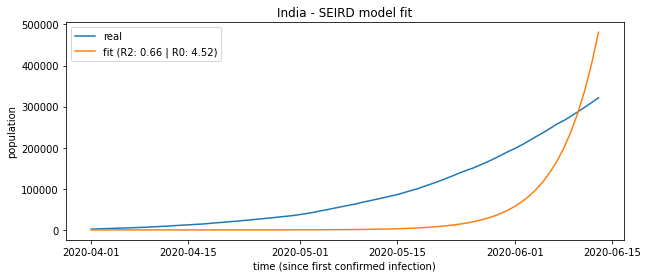

In [32]:
ind.plot_fit()

In [33]:
ind.simulation()

DatetimeIndex(['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
               '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16',
               '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20',
               '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24',
               '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28',
               '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02',
               '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06',
               '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10',
               '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
               '2020-05-15', '2020-05-16', '2020-05-17', '2020-05-18',
               '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22',
               '2020-05-23', '2020-05-24', '2020-05-25', '2020-05-26',
      

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

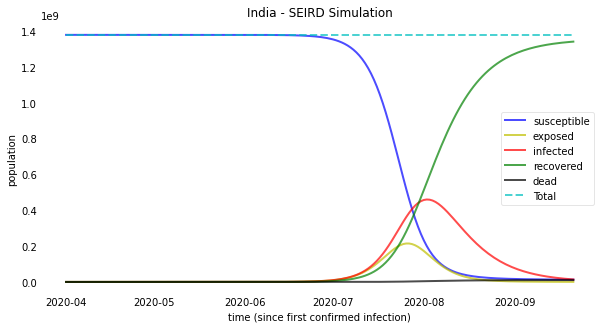

In [34]:
ind.plot_simulation()